In [2]:
import nestpy
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:

#create detector
detector = nestpy.DetectorExample_LUX_RUN03()

# inspect detector parameters
z_max = detector.get_TopDrift() 
radius = detector.get_radius() # right fid radius?? TBD
dt_min = detector.get_dt_min() # right min dt?? TBD
dt_max = detector.get_dt_max() # right max dt?? TBD
anode = detector.get_anode()
cathode = detector.get_cathode()
T_Kelvin = detector.get_T_Kelvin() 
p_bar = detector.get_p_bar() 

# print detector parameters (satisfied with the setting?)
print('T_Kelvin:', T_Kelvin)
print('radius:', radius)
print('dt_min:', dt_min)
print('dt_max:', dt_max)
print('anode:', anode)
print('cathode:', cathode)
print('T_Kelvin:', T_Kelvin)
print('p_bar:', p_bar)

T_Kelvin: 173.0
radius: 200.0
dt_min: 80.0
dt_max: 130.0
anode: 549.2
cathode: 55.9
T_Kelvin: 173.0
p_bar: 1.57


In [4]:
# run a single recoil
keV=10
type_num = nestpy.INTERACTION_TYPE(0) # NR
pos_x, pos_y, pos_z = 0., 0., z_max/2.
inField=180

obs = nestpy.runNEST(
    detector, 
    keV, 
    type_num, 
    inField, 
    pos_x, 
    pos_y, 
    pos_z, 
    seed=0
    )

s1c_phd = obs.s1c_phd
s2c_phd = obs.s2c_phd
print(s1c_phd, s2c_phd)

6.532790408546776 590.173217059425


In [5]:
# run many recoils with vectorized arguments

# somehow detector is deleted once runNEST is finished

n_events=100
keV=np.linspace(0, 100, n_events)
type_num = nestpy.INTERACTION_TYPE(0) # NR

# uniformly sample (x,y,z) in cylindar colume
r2 = np.random.uniform(low=0, high=radius*radius, size=n_events)
r = np.sqrt(r2)
phi = np.random.uniform(low=0, high=2*np.pi, size=n_events)
pos_x = r * np.cos(phi);
pos_y = r * np.sin(phi);
pos_z = np.random.uniform(low=0, high=z_max, size=n_events)

inField=180
obs_arr = nestpy.runNEST_vec(
    nestpy.DetectorExample_LUX_RUN03(), 
    keV.tolist(), 
    type_num, 
    inField, 
    pos_x.tolist(), 
    pos_y.tolist(), 
    pos_z.tolist(), 
    0
    )

s1 = np.array(obs_arr.s1c_phd)
s2 =np.array(obs_arr.s2c_phd)


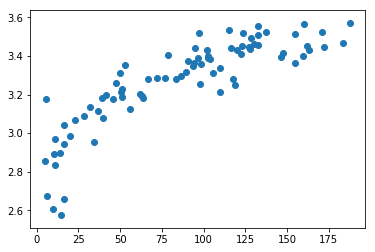

In [6]:
# apply a detector cut and plot it
cut_mask = np.logical_and(s2>0, s1>0)
plt.scatter(s1[cut_mask], np.log10(s2[cut_mask]))
plt.xlabel('s1 [phd]')
plt.ylabel('log10(s2 [phd])')
plt.show()

# example of using NEST recoil generators

In [ ]:
# NEST WIMP spectrum comes from: 
# Phys. Rev. D 82 (2010) 023530 (McCabe)

Er = np.linspace(0.01, 3, 400)

spec = nestpy.TestSpectra()
WIMP_dRate_vec = np.vectorize(spec.WIMP_dRate)


dR_3GeV = WIMP_dRate_vec(Er, m_GeV=3)
dR_6GeV = WIMP_dRate_vec(Er, m_GeV=6)
dR_10GeV = WIMP_dRate_vec(Er, m_GeV=10)

plt.plot(Er, dR_3GeV, label='3 GeV')
plt.plot(Er, dR_6GeV, label='6 GeV')
# plt.plot(Er, dR_10GeV, label='10 GeV')
plt.legend()
plt.yscale('log')
plt.title('$\sigma=10^{-36}$ cm$^2$')
plt.xlabel('Er [keVnr]')
plt.ylabel('dR/dE [counts/(kg-d-keV)]')
plt.show()
